# TAREA # 1: COMPRENDER EL PROBLEMA Y EL CASO PRÁCTICO


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figura 1. Clasificación de Enfermedades utilizando Deep Learning 
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=1t-Q7JllEobw8YwV3wcTuMA12J9JArfwp)

![alt text](https://drive.google.com/uc?id=1pNAshUhBxksQcrTfulYmUKXUPOmWbXb0)

# TAREA # 2: IMPORTAR LIBRERÍAS Y CONJUNTO DE DATOS

In [22]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [23]:
# Especificar el directorio del conjunto de entrenamiento
# get working directory
train_cwd = os.getcwd().replace('\\', '/') + "/Dataset"
test_cwd = os.getcwd().replace('\\', '/') + "/Test"


In [24]:
# Listar las carpetas de dicho directorio
os.listdir(test_cwd)

['0', '1', '2', '3']

In [25]:
# Utilizar el generador de imágenes para generar datos de imágenes de tensores y normalizarlos
# Utilizar el 20% de los datos para la validación cruzada posterior
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [26]:
# Genere lotes de 40 imágenes
# El número total de imágenes es 133 * 4 = 532 imágenes
# El entrenamiento usará es 428 (80%) y la validación usará 104 (20%)
# Realizar muestreo aleatoria y cambio del tamaño en las imágenes
train_generator = image_generator.flow_from_directory(
    directory=train_cwd,
    target_size=(256, 256), 
    batch_size=40,
    class_mode='categorical',
    subset='training',
    shuffle=True, # randomize the order of the images
    seed=42
)

validation_generator = image_generator.flow_from_directory(
    directory=train_cwd,
    target_size=(256, 256),
    batch_size=40,
    class_mode='categorical',
    subset='validation', 
    shuffle=True, # randomize the order of the images
    seed=42
)

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [27]:
# Generar un lote de 40 imágenes y etiquetas
train_images, train_labels = next(train_generator) # get a batch of 40 images and labels

In [28]:
train_images.shape

(40, 256, 256, 3)

In [64]:
# Traductor de cada Etiqueta
label_names = {0: 'Covid', 1: 'Normal', 2: 'V.Pneumonia', 3: 'B.Pneumonia'}

# TAREA #3: VISUALIZACIÓN DEL DATASET

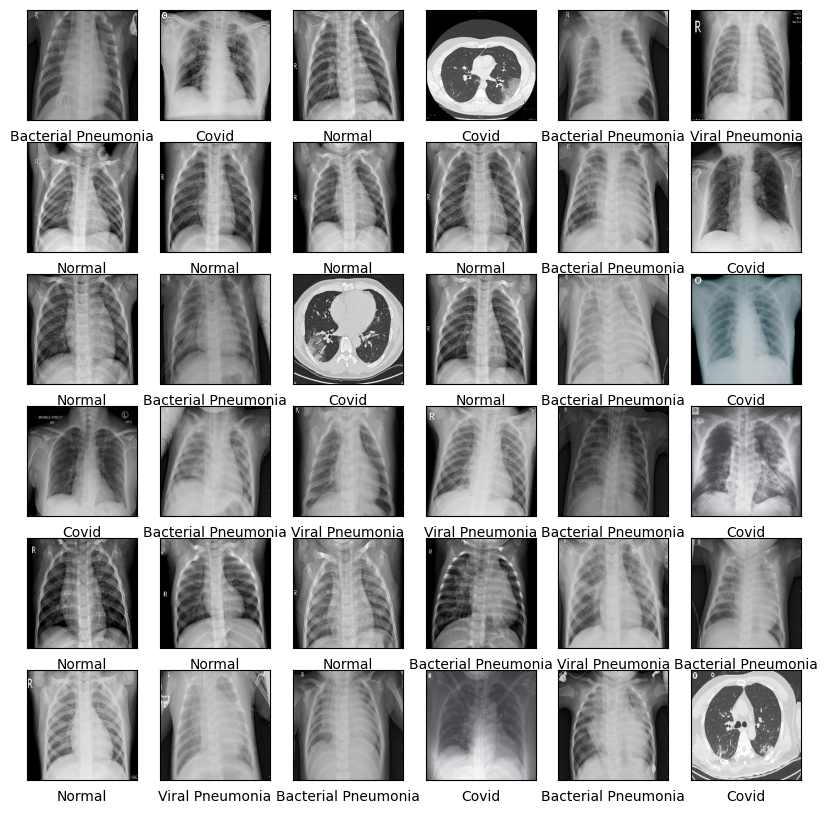

In [30]:
# Crea una matriz de 36 imágenes junto con sus etiquetas correspondientes
plt.figure(figsize=(10,10))

L = 6
W = 6

for i in range(36):

    # Crea un subplot de 6x6
    plt.subplot(L,W,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])

    # Etiqueta la imagen con el nombre de la clase
    plt.xlabel(label_names[np.argmax(train_labels[i])]) # np.argmax returns the index of the largest value in the array

plt.show()  

# TAREA #4: ENTENDER LA TEORÍA Y LA INTUICIÓN DETRAS DE LAS REDES NEURONALES PROFUNDAS

![alt text](https://drive.google.com/uc?id=1e4bFs8Fh2Bp4ueRi9Q9SASRWZ2SwShJX)

![alt text](https://drive.google.com/uc?id=1zsKnK9bQVjUt5Z38gEK3qnIoafRR6i1c)

![alt text](https://drive.google.com/uc?id=1mL13x1d9uAItMFwtV_9r-fKqQp8DjfQo)

![alt text](https://drive.google.com/uc?id=1-se5iR8RsZ4Bold3MK60hDpL0qky7H97)

# TEORÍA #5: ENTENDER LA TEORÍA Y LA INTUICIÓN DETRÁS DEL APRENDIZAJE POR TRANSFERENCIA

![alt text](https://drive.google.com/uc?id=1ypOE6WINmjunchutKTSUbx4FCzuYUyqC)

![alt text](https://drive.google.com/uc?id=16Rhq_7flyuy5oS1vEJ7p3l1Y8irU7Zwg)

![alt text](https://drive.google.com/uc?id=1hCdV7lmgADpw8jV7nf0KO3mMzIMuMZDM)

![alt text](https://drive.google.com/uc?id=1gHDvwWJBBD5d94HPpSydQLb6pjTfknrK)

# TAREA #6: IMPORTAR EL MODELO CON PESOS PRE ENTRENADOS

In [31]:
# Crear el modelo de red neuronal convolucional

# Utilizar el modelo ResNet50
basemodel = ResNet50(
    weights='imagenet', 
    include_top=False, # do not include the fully-connected layer at the top of the network
    input_shape=(256, 256, 3))

In [32]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# TAREA #7: CONSTRUIR Y ENTRENAR UN MODELO DE DEEP LEARNING

In [33]:

# Congelar las capas del modelo ResNet50
for layer in basemodel.layers[:-10]:
    layer.trainable = False

# Crear una nueva capa de salida
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel) # reduce the size of the feature maps to 4x4 pixels 
headmodel = Flatten(name="flatten")(headmodel) # flatten the feature maps to a single vector
headmodel = Dense(256, activation="relu")(headmodel) # add a fully-connected layer with 256 neurons
headmodel = Dropout(0.3)(headmodel) # add a dropout layer with a dropout rate of 0.3
headmodel = Dense(128, activation="softmax")(headmodel) # add a fully-connected layer with 128 neurons and a softmax activation function
headmodel = Dropout(0.2)(headmodel) # add a dropout layer with a dropout rate of 0.2
headmodel = Dense(4, activation="softmax")(headmodel) # add a fully-connected layer with 4 neurons and a softmax activation function

model = Model(inputs=basemodel.input, outputs=headmodel)

In [34]:
model.compile(
    loss='categorical_crossentropy', # use categorical cross-entropy loss function since we have 4 classes 
    optimizer=optimizers.RMSprop(learning_rate=1e-4, decay=1e-6), # use RMSprop optimizer
    metrics=['accuracy'] # use accuracy as the evaluation metric
)

In [35]:
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    mode="min"
)

In [36]:
checkpointer = ModelCheckpoint(filepath='weights.h5', verbose=1, save_best_only=True)

In [40]:
train_generator = image_generator.flow_from_directory(
    directory=train_cwd,
    target_size=(256, 256),
    batch_size=4,
    class_mode='categorical',
    subset='training',
    shuffle=True, # randomize the order of the images
)

validation_generator = image_generator.flow_from_directory(
    directory=train_cwd,
    target_size=(256, 256),
    batch_size=4,
    class_mode='categorical',
    subset='validation',
    shuffle=True, # randomize the order of the images
)

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [41]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//4, # 428 images = batch_size * steps
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//4, # 104 images = batch_size * steps
    callbacks=[earlystopping] # add checkpointer to save the best model
)

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 1.3069 - accuracy: 0.4042
Epoch 1: val_loss did not improve from 1.29009
107/107 [==============================] - 43s 399ms/step - loss: 1.3069 - accuracy: 0.4042 - val_loss: 1.3081 - val_accuracy: 0.4231
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 1.2827 - accuracy: 0.4346
Epoch 2: val_loss improved from 1.29009 to 1.28861, saving model to weights.h5
107/107 [==============================] - 42s 394ms/step - loss: 1.2827 - accuracy: 0.4346 - val_loss: 1.2886 - val_accuracy: 0.4615
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 1.2817 - accuracy: 0.4252
Epoch 3: val_loss did not improve from 1.28861
107/107 [==============================] - 42s 395ms/step - loss: 1.2817 - accuracy: 0.4252 - val_loss: 1.3188 - val_accuracy: 0.3846
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 1.2768 - accuracy: 0.4182
Epoch 4: val_loss improved from 1.28861 t

# TAREA #8: EVALUAR EL MODELO DE DEEP LEARNING ENTRENADO

In [42]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

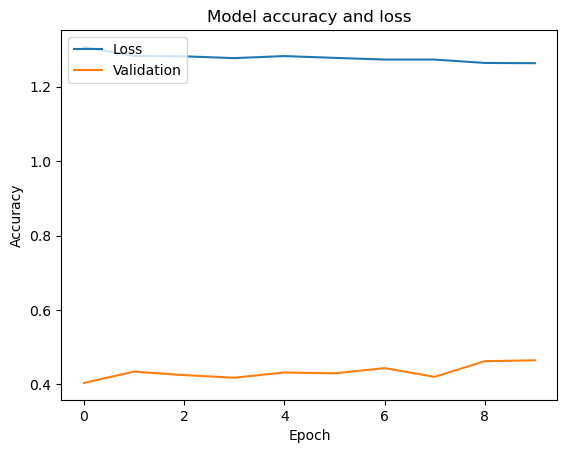

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

plt.title('Model accuracy and loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation'], loc='upper left')
plt.show()

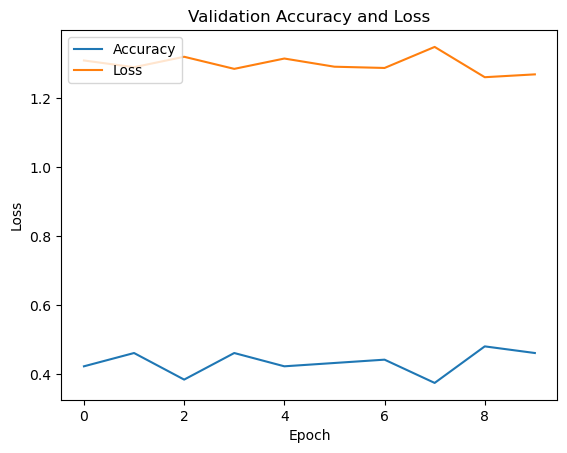

In [54]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])

plt.title('Validation Accuracy and Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [57]:
# test our model with the test dataset
test_generator = image_generator.flow_from_directory(
    directory=test_cwd, # use the test directory
    target_size=(256, 256), # resize all images to 256x256
    batch_size=1, # we only need to pass one image at a time to the network
    class_mode='categorical', # since we use binary_crossentropy loss, we need binary labels
    shuffle=True # randomize the order of the images
)

# evaluate the model
evaluate = model.evaluate_generator(test_generator, steps=test_generator.n // 4, verbose=1)

print('Test accuracy:', evaluate[1])

Found 40 images belonging to 4 classes.
 1/10 [==>...........................] - ETA: 1s - loss: 1.1431 - accuracy: 1.0000

C:\Users\jcr\AppData\Local\Temp\ipykernel_25720\600672288.py:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps=test_generator.n // 4, verbose=1)


10/10 [==============================] - 1s 90ms/step - loss: 1.2847 - accuracy: 0.6000
Test accuracy: 0.6000000238418579


In [60]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_cwd))):
    for item in os.listdir(os.path.join(test_cwd, str(i))):
        img = cv2.imread(os.path.join(test_cwd, str(i), item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)


1/1 [==============================] - 0s 91ms/step


In [61]:
score = accuracy_score(original, prediction)
print(f"Model accuracy {score}")

Model accuracy 0.475


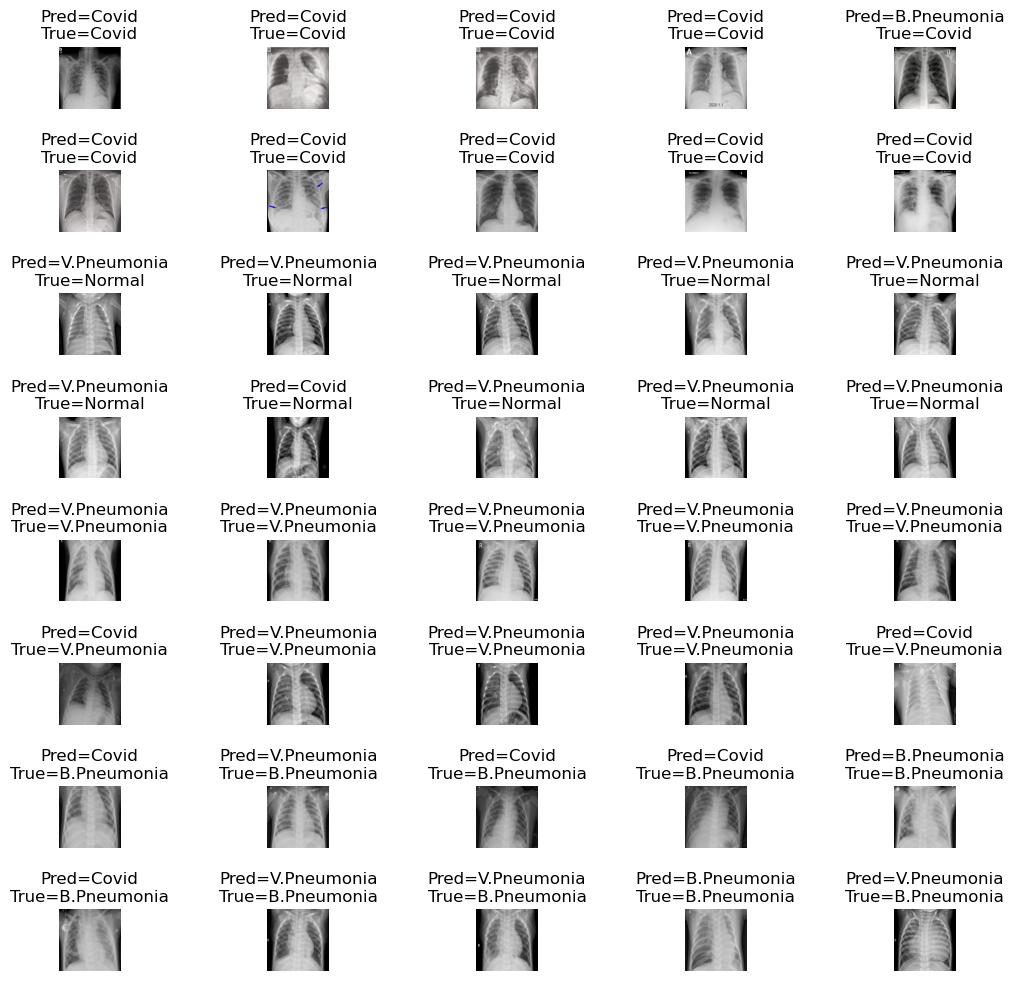

In [66]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title(
        f"Pred={str(label_names[prediction[i]])}\nTrue={str(label_names[original[i]])}")
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2, hspace=1)

In [67]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.00      0.00      0.00        10
           2       0.38      0.80      0.52        10
           3       0.67      0.20      0.31        10

    accuracy                           0.48        40
   macro avg       0.40      0.48      0.38        40
weighted avg       0.40      0.47      0.38        40



c:\Users\jcr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jcr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jcr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


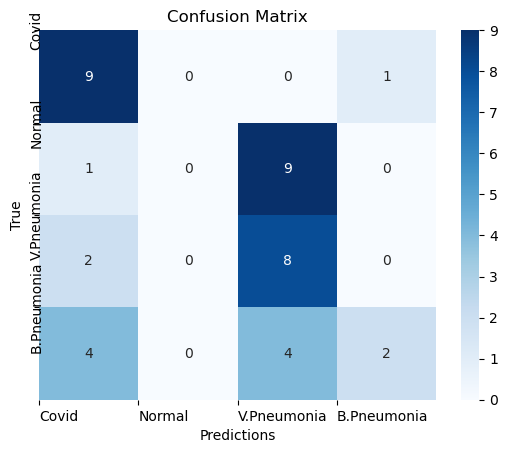

In [98]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
sns.heatmap(cm, annot = True, fmt='g', cmap='Blues')
plt.xlabel("Predictions")
plt.ylabel("True")
plt.title("Confusion Matrix")
# add labels
plt.xticks([0, 1, 2, 3], label_names.values(), ha='left', fontsize=10)
plt.yticks([0, 1, 2, 3], label_names.values(), ha='left', fontsize=10)
plt.show()